In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
+ \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
$$

$$
H_I = \hbar \Sigma_x E(t).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|³}.
$$

In [62]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

# ENERGY LANDSCAPE, c = 1, hbar = 1
omega_a = 1.
fixed_lam = 2 * np.pi / omega_a                # propto omega_a;  energysplitting of the atom, when ground state is set to 0
alpha = 1. # coupling strength of the dipoles       Fine structure const?
# LINBLAD OPS
gamma_0 = .0   # decay rate of the atoms
gamma_phi = .0 # dephasing rate of the atoms

# TOPOLOGY
distance = 1 * fixed_lam # defining topology

# TIME EVOLUTION
last_pulse = 10# * gamma_0
last_det_t = 1 * last_pulse
time_steps = 50
times = np.linspace(0, last_det_t, time_steps) # list of times

def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer
tolerance = count_decimal_digits(times[1]) - 2

In [63]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

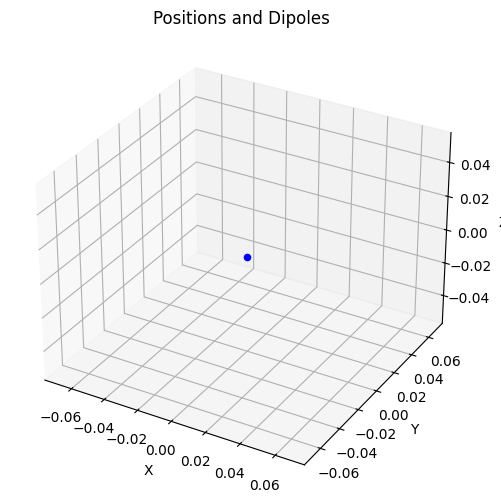

In [64]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [65]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# combined dofs
sm_list = []    # lowering operators of atomic system
S_x = 0         # collective sigma_x operator for the system

for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    S_x += op + op.dag()

In [66]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += omega_a *op # Diagonals except for |0><0|
    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)

H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.        ]
 [0.         6.28318531]]

In [67]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

op_list = sm_list  # Operators combining the cavity (qeye(2)) and the atomic lowering operator (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic ground and excited levels
e_op_list = [
    basis(N_atoms + 1, i) * basis(N_atoms + 1, i).dag()
    for i in range(N_atoms + 1)]

In [68]:
# create the time dependant evolution

I = S_x
E12 = 100 # Amplitude of laser pulses 1,2
E0s = [E12, E12, E12/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]
Delta_ts = [last_pulse/100, last_pulse/100, last_pulse/100] # narrow width of the pulses
phi12 = 2 * np.pi         # phis = [phi12, phi12, 0]  # Phase-kick?, pulse 1 and 2 are phase locked!

def heaviside(x):
    return 1 if x >= 0 else 0

def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = 1 / np.sqrt(2) * args['E0'] * heaviside(Delta - (t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(args['omega'] * (t - t0) + args['phi'])
    return E

HI = [-I, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)

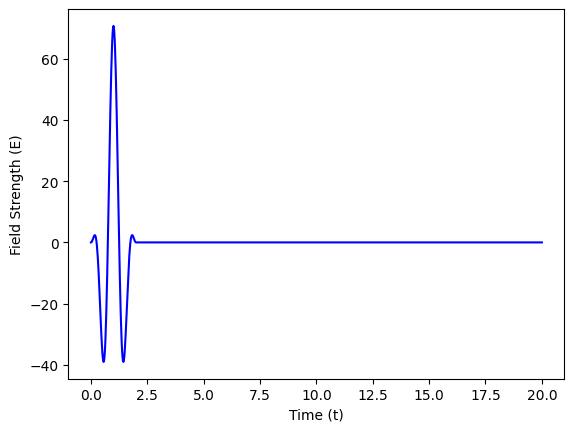

In [69]:
# VIZUALIZE THE FIELD AS AN EXAMPLE
#
t_values = np.linspace(0, 2 * last_pulse, 1000)
field_args = {
    'E0': E12,
    'omega': omega_a,
    'Delta': last_pulse / 10,
    'phi': phi12,
    'time': last_pulse / 10
}
electric_field = [El_field(t, field_args) for t in t_values]
plt.figure()
plt.plot(t_values, electric_field, label='Electric Field E(t)', color='blue')
plt.xlabel('Time (t)')
plt.ylabel('Field Strength (E)')
plt.show()

In [70]:
# evolution with t
# initial state
psiini = basis(N_atoms+1, 0) # = |g>_atom

#
# PREPROCESSING
#
# Define the phases, coherence times, and waiting times
phases = [0] # [i * np.pi/2 for i in range(4)]

# Initialize the main dictionary to hold the structure
data_dict_stage1 = {}
data_dict_stage2 = {}

# Loop through each phase φ
for phi in phases:
    data_dict_stage1[phi] = {}  # Stage 1 copy of the phase
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase

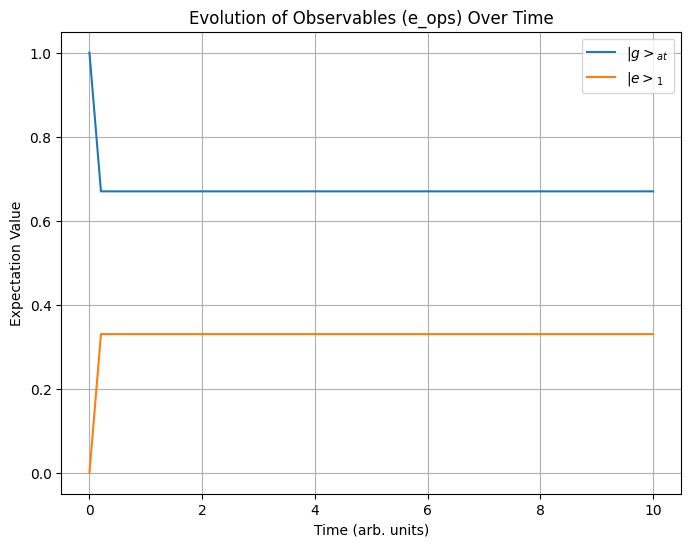

In [71]:
#
# CALCULATIONS
#

# (first laser pulse)
times_0 = times

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'phi': phi12,  # Use the phase 0
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': E0s[0]  # E0 value
    }

    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)): # save only the states that make sense
        if (2 * Delta_ts[0] <= times_0[i] <= last_pulse - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is indirectly stored in the index i (key of the dictionary)

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#
# PLOT TO CHECK the evolution
#
# Plot each observable in `e_ops`
plt.figure(figsize=(8, 6))
for i, e_op_expect in enumerate(result_0.expect):
    if i ==0:
        label=r"$|g>_{at}$"
    else:
        label=f"$|e>_{i}$"
    plt.plot(result_0.times, e_op_expect, label=label)

# Add labels and legend
plt.xlabel("Time (arb. units)")
plt.ylabel("Expectation Value")
plt.title("Evolution of Observables (e_ops) Over Time")
plt.legend()
plt.grid()
plt.show()
#pprint.pprint(data_dict_stage1)

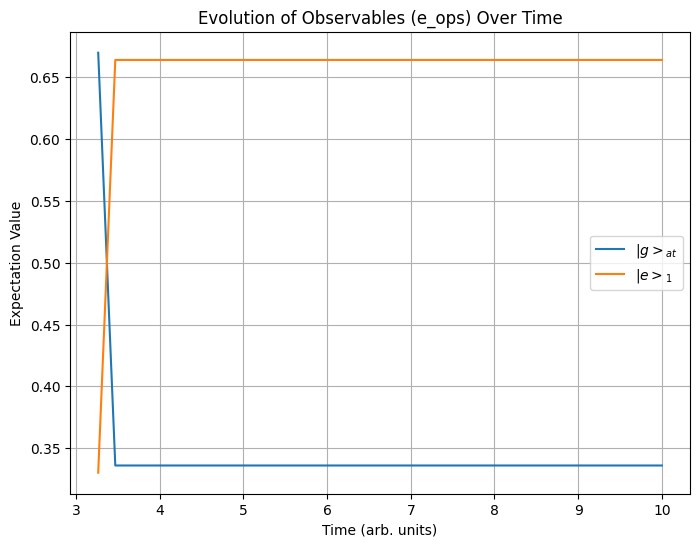

In [72]:
# (second laser pulse)
# Iterate over the phi values
for phi, dic in data_dict_stage1.items():
    # Iterate over the tau values and states after tau, from there make the second laser pulse
    for i, psiini_1 in dic.items():
        times_1 = times[i:]
        args_1 = {
            'phi': phi12,
            'time': times_1[0] + Delta_ts[1],
            'omega': omegas[1],
            'Delta': Delta_ts[1],
            'E0': E0s[1]
        }

        # Solve the system using mesolve (second laser pulse)
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

        if phi == 0 and i == 5:
            # Compute electric field values
            E = np.array([El_field(time, args_1) for time in times_1])

#            # Plot the electric field
#            plt.figure(figsize=(8, 6))
#            plt.plot(times_1, E, label="Electric Field (E(t))")
#            plt.xlabel("Time (t)")
#            plt.ylabel("Electric Field (E(t))")
#            plt.title("Electric Field Plot for Second Laser Pulse")
#            plt.grid()
#            plt.legend()
#            plt.show()

        current_dict = {}
        for j in range(len(times_1)): # save only the states that make sense
            if (times[i] + 2 * Delta_ts[1] <= times_1[j] <= last_pulse - 2 * Delta_ts[2]):
                current_dict[j] = result_1.states[j] # T is stored in the information j, together with i

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2[phi][i] = current_dict
        #
        # PLOT TO CHECK the evolution
        #
        # Plot each observable in `e_ops`
        if phi == 0 and i == time_steps//3:
            plt.figure(figsize=(8, 6))
            for i, e_op_expect in enumerate(result_1.expect):
                if i ==0:
                    label=r"$|g>_{at}$"
                else:
                    label=f"$|e>_{i}$"
                plt.plot(result_1.times, e_op_expect, label=label)

            # Add labels and legend
            plt.xlabel("Time (arb. units)")
            plt.ylabel("Expectation Value")
            plt.title("Evolution of Observables (e_ops) Over Time")
            plt.legend()
            plt.grid()
            plt.show()

# After processing each coherence time, you can optionally print the current state of the dictionary
#pprint.pprint(data_dict_stage2)

In [73]:
def truncate_number(number, decimals=0):
    factor = 10.0 ** decimals
    return int(number * factor) / factor

In [74]:
# (third laser pulse)
data_dict = {}

# Iterate over the phi values
for phi, dic in data_dict_stage2.items():
    if phi not in data_dict:
        data_dict[phi] = {}

    # Iterate over the tau values
    for i, dic1 in dic.items():
        times_1 = times[i:]

        # Iterate over the T values and make the last laser pulse
        for j, psiini_2 in dic1.items():
            waiting_time_j = times_1[j] - times_0[i] + Delta_ts[2] - Delta_ts[1]
            T = truncate_number(waiting_time_j, tolerance-2) # Round to tolearance decimal places carefull!

            if T not in data_dict[phi]:
                data_dict[phi][T] = {}

            times_2 = times_1[j:]
            args_2 = {
                'phi': 0,       #last pulse has no phase kick
                'time': times_2[0] + Delta_ts[2],  # Duration for the 2nd pulse
                'omega': omegas[2],  # Omega for the 2nd pulse
                'Delta': Delta_ts[2],  # Delta for the 2nd pulse
                'E0': E0s[2]  # E0 for the 2nd pulse
            }

            # (last laser pulse)
            result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, args=args_2, options=options)

            # Iterate over the states in result_2 and store the ones that meet:
            # ONLY the first state with T >= times_2[0] + 2 Delta_ts[2] is important -> break
            for k in range(len(times_2)):
                if (times_1[j] + 2 * Delta_ts[2] <= times_2[k] <= last_det_t):

                    coherence_time_i = times_0[i] + Delta_ts[1] - Delta_ts[0]
                    tau = truncate_number(coherence_time_i, tolerance-2) # Round to tolearance decimal places carefull!

                    if tau not in data_dict[phi][T]:
                        data_dict[phi][T][tau] = []

                    # store the final time and the final state
                    t = truncate_number(times_2[k], tolerance-2)
                    data_dict[phi][T][tau].append((t, result_2.states[k])) # Round to tolearance decimal places carefull!

#pprint.pprint(data_dict)
# The final data_dict will now contain the results for each φ, τ, and T

In [75]:
#
# POST-PROCESSING
#

# Create an empty dictionary `accumulated_data` to store lists of (\psi) for each ((\tau, T, t)):
averaged_data_dict = {}
for T, tau_dict in data_dict[phases[0]].items():
    if T not in averaged_data_dict:
        averaged_data_dict[T] = {}
    for tau, T_list in tau_dict.items():
        if tau not in averaged_data_dict[T]:
            averaged_data_dict[T][tau] = {}

        for t, psi_mean in T_list:
            if t not in averaged_data_dict[T][tau]:
                averaged_data_dict[T][tau][t] = None

            for phi in data_dict.keys():
                for T1 in data_dict[phi].keys():
                    if T1 == T:
                        for tau1 in data_dict[phi][T1].keys():
                            if tau1 == tau:
                                for t1, psi1 in data_dict[phi][T1][tau1]:
                                    if t1 == t:
                                        psi_mean += psi1
                                    continue
                            continue
                    continue

            psi_mean /= len(data_dict.keys())
            expect_val = expect(S_x, psi_mean)
            averaged_data_dict[T][tau][t] = expect_val
# <psi | S_x | psi>

In [76]:
#
# PREPARE FOR PLOTTING
#
T_dictionary = {}

for T in averaged_data_dict.keys():  # Extract all unique T values
    taus = list(averaged_data_dict[T].keys())
    ts = sorted(set(t for tau in taus for t in averaged_data_dict[T][tau].keys()))
    data = np.zeros((len(ts), len(taus)))  # or dtype=np.complex128 if needed
    # Populate the 2D data array with the corresponding expect_vals
    for i, t in enumerate(ts):  # Iterate over ts
        for j, tau in enumerate(taus):  # Iterate over taus
            # Check if the specific t exists for the given tau
            if t in averaged_data_dict[T][tau]:
                data[i, j] = averaged_data_dict[T][tau][t]  # Assign expect_val

    # Store T-specific results in the dictionary
    T_dictionary[T] = {
        "ts": ts,  # Local ts specific to T
        "taus": taus,  # Local taus specific to T
        "data": data,  # Smaller T-specific grid
    }

# Loop through each T in the T_dictionary (excluding "global")
valid_indices = np.linspace(0, time_steps - 1, time_steps//3, dtype=int)  # Equally distributed indices

smallest_key = min(averaged_data_dict.keys())  # first T value gives biggest data-set
# Retrieve the global taus and ts using the smallest key
global_taus = T_dictionary[smallest_key]["taus"]  # Local taus for the current T
global_ts = T_dictionary[smallest_key]["ts"]  # Local ts for the current T

#print(T_dictionary)

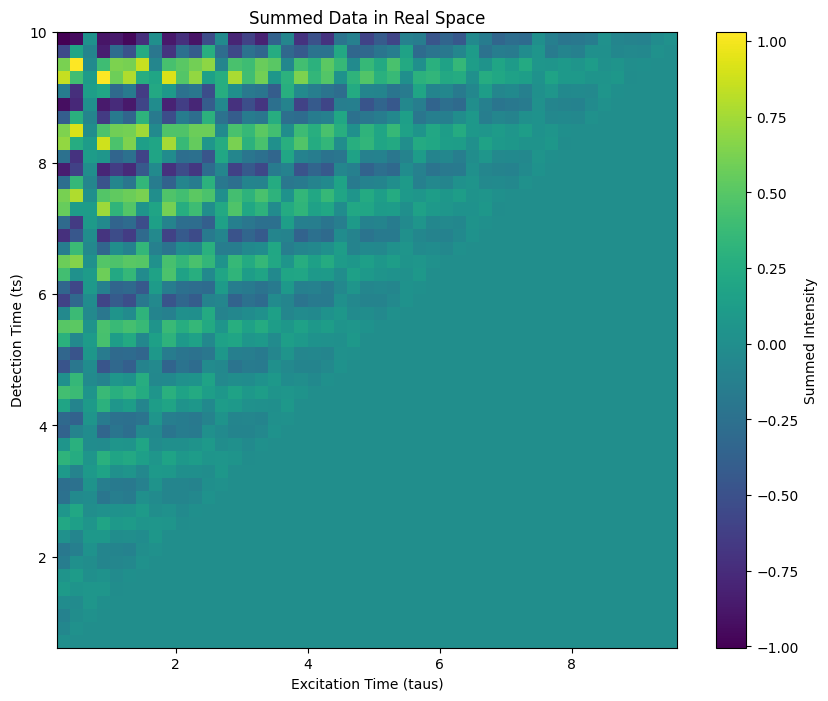

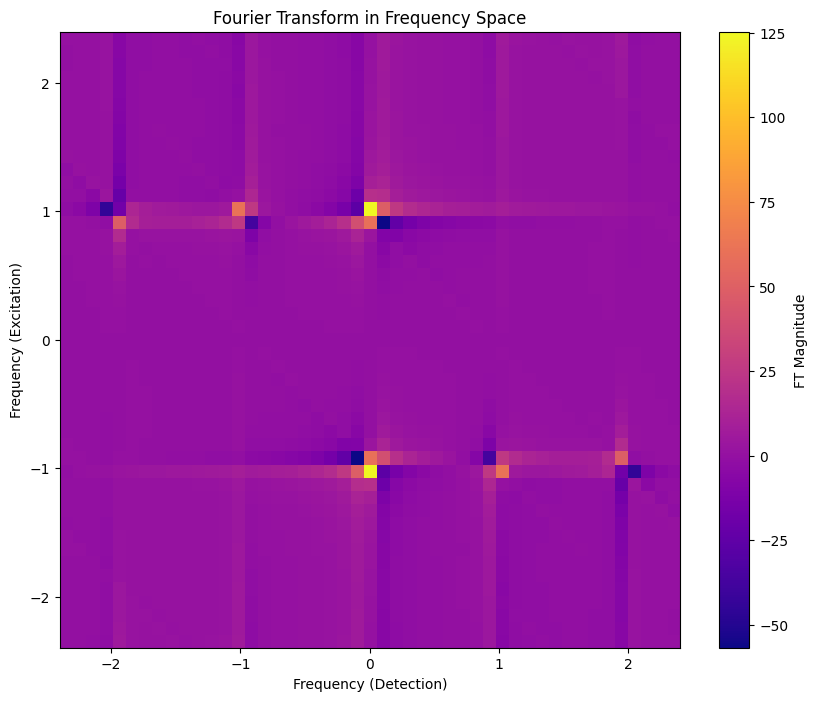

In [77]:
#
# PLOT THE WHOLE DATA AVG and its FT
#
global_sum = np.zeros((len(global_ts), len(global_taus)))

# Sum all data into global sum
for T, T_data in T_dictionary.items():
    ts = T_data["ts"]
    taus = T_data["taus"]
    data = T_data["data"]

    t_global_indices = [global_ts.index(t) for t in ts]
    tau_global_indices = [global_taus.index(tau) for tau in taus]
    for local_i, global_i in enumerate(t_global_indices):
        for local_j, global_j in enumerate(tau_global_indices):
            global_sum[global_i, global_j] += data[local_i, local_j]
global_sum /= len(T_dictionary)

# Plot the global sum
plt.figure(figsize=(10, 8))
extent = [min(global_taus), max(global_taus), min(global_ts), max(global_ts)]
plt.imshow(global_sum, extent=extent, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="Summed Intensity")
plt.title("Summed Data in Real Space")
plt.ylabel("Detection Time (ts)")
plt.xlabel("Excitation Time (taus)")
plt.show()

# Perform 2D Fourier Transform
ft_data = np.fft.fft2(global_sum)
ft_data = np.fft.fftshift(ft_data)  # Shift zero frequency to the center
freq_ts = np.fft.fftshift(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))
freq_taus = np.fft.fftshift(np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))

ft_data = -freq_ts[:, np.newaxis] * np.imag(
    ft_data)

# Plot the Fourier Transform result
plt.figure(figsize=(10, 8))
extent = [min(freq_taus), max(freq_taus), min(freq_ts), max(freq_ts)]
plt.imshow(ft_data, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label="FT Magnitude")
plt.title("Fourier Transform in Frequency Space")
plt.xlabel("Frequency (Detection)")
plt.ylabel("Frequency (Excitation)")
plt.show()

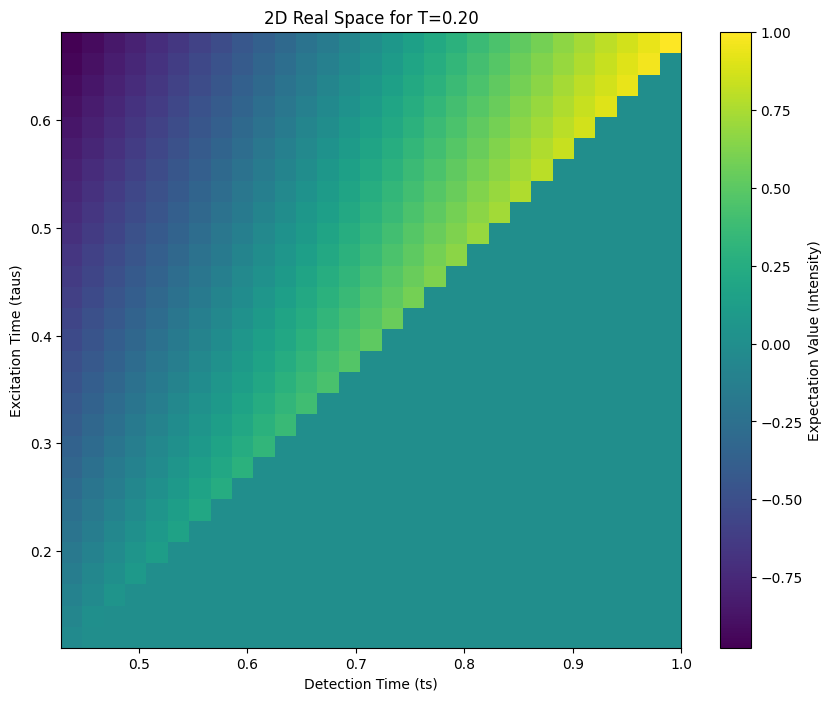

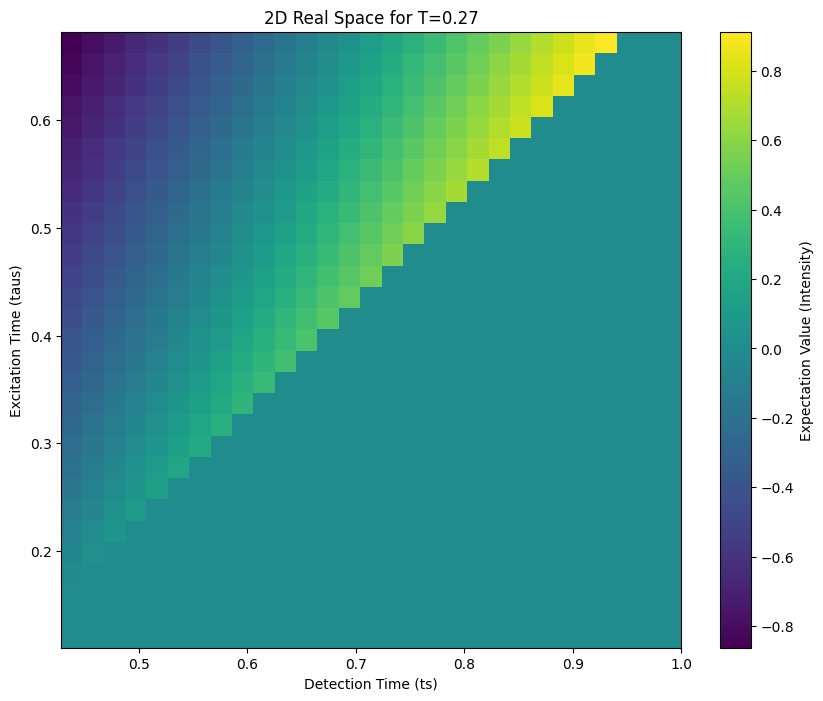

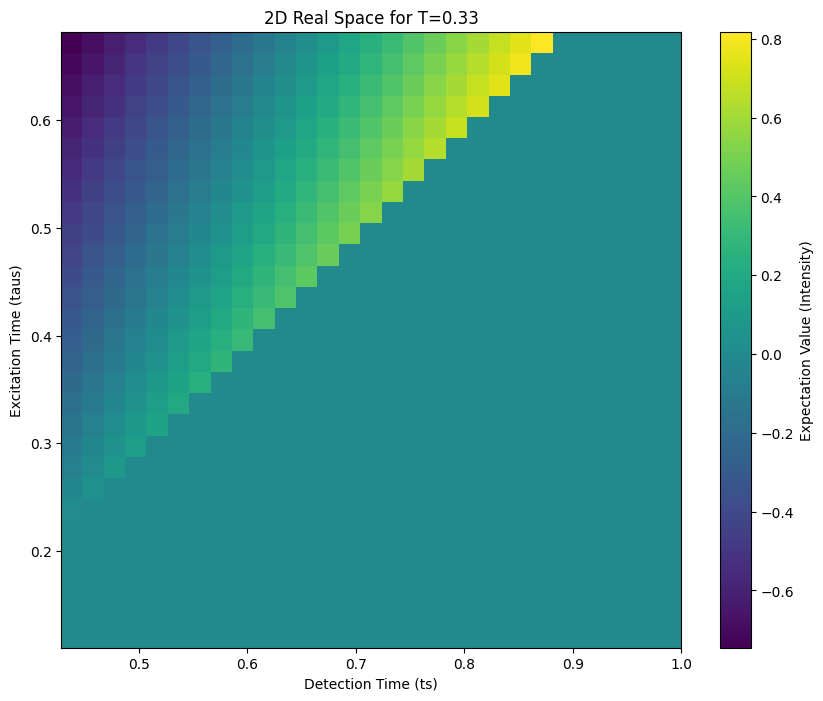

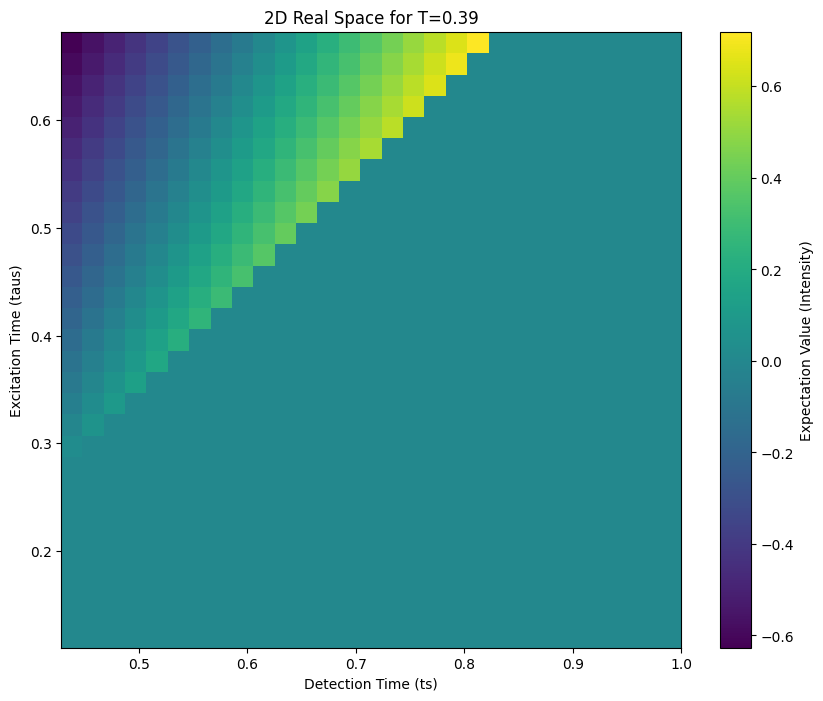

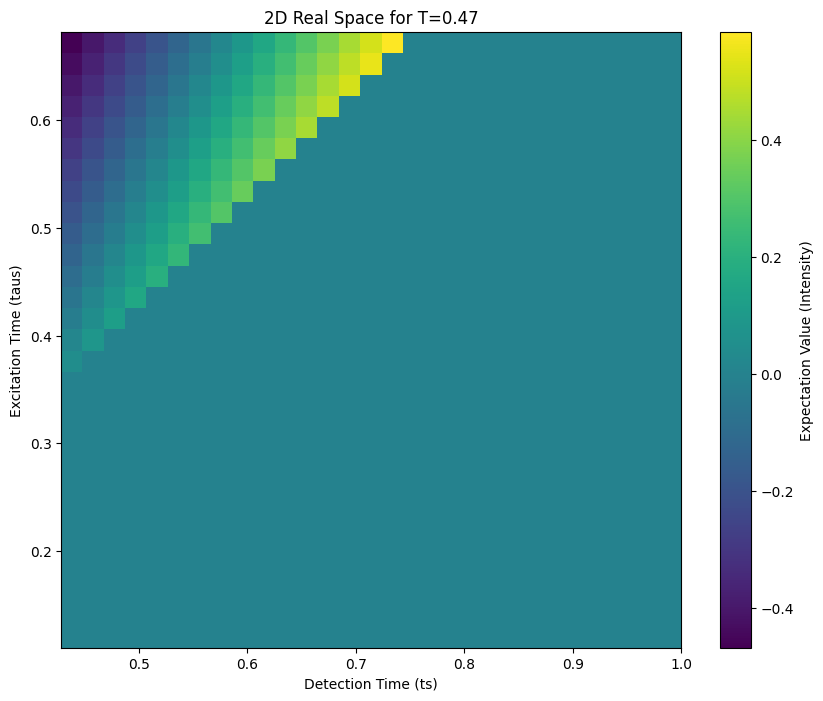

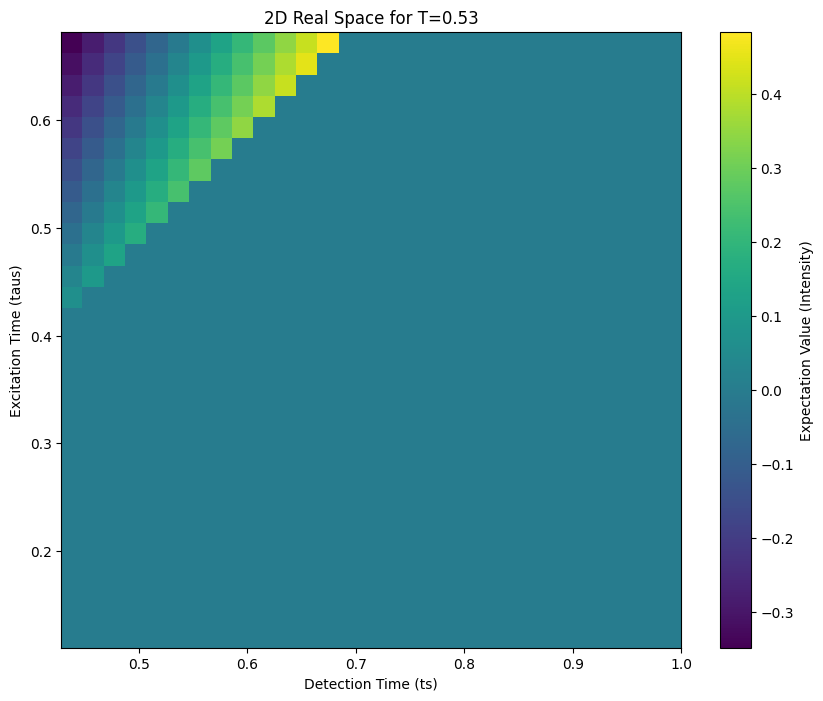

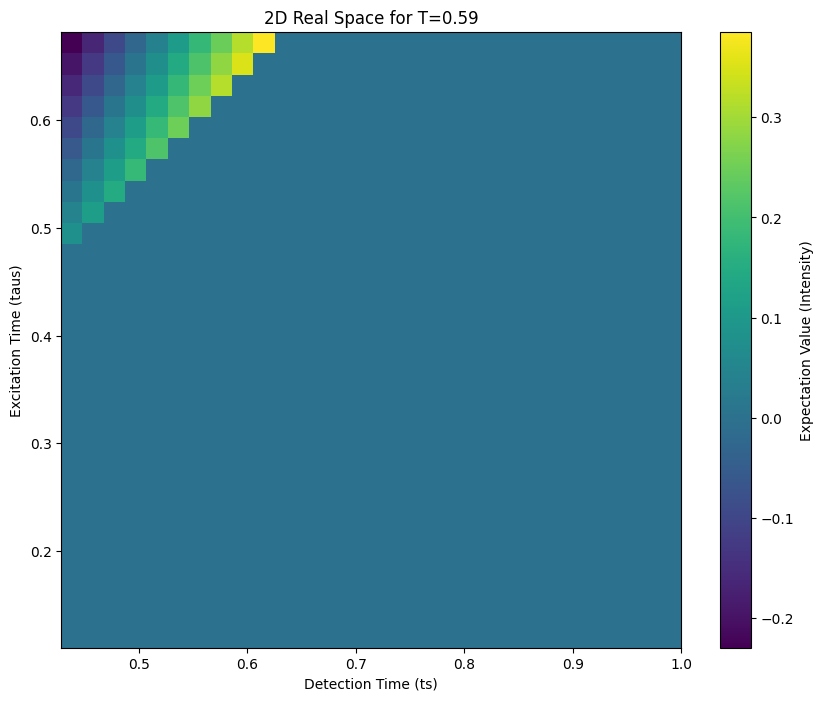

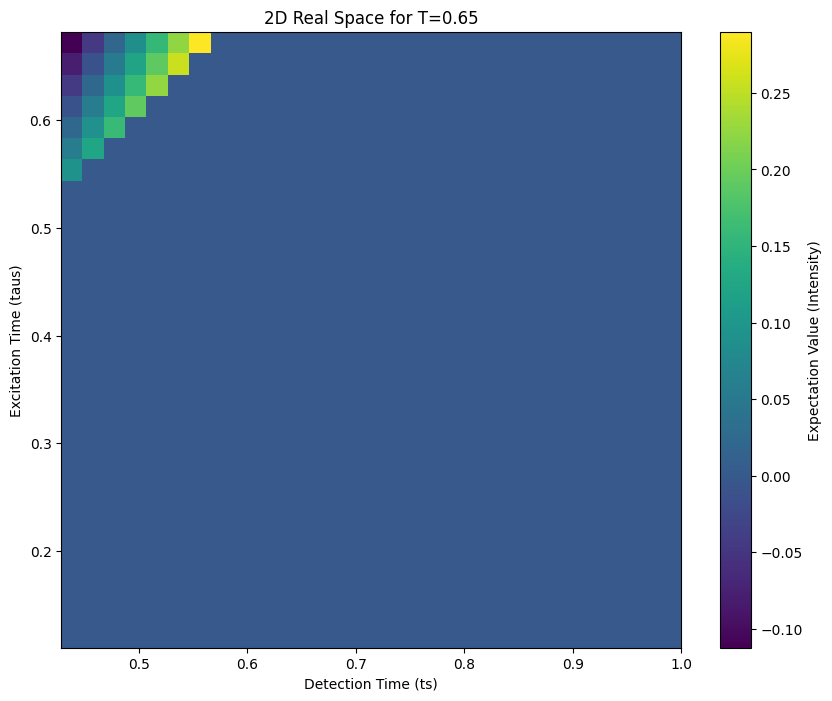

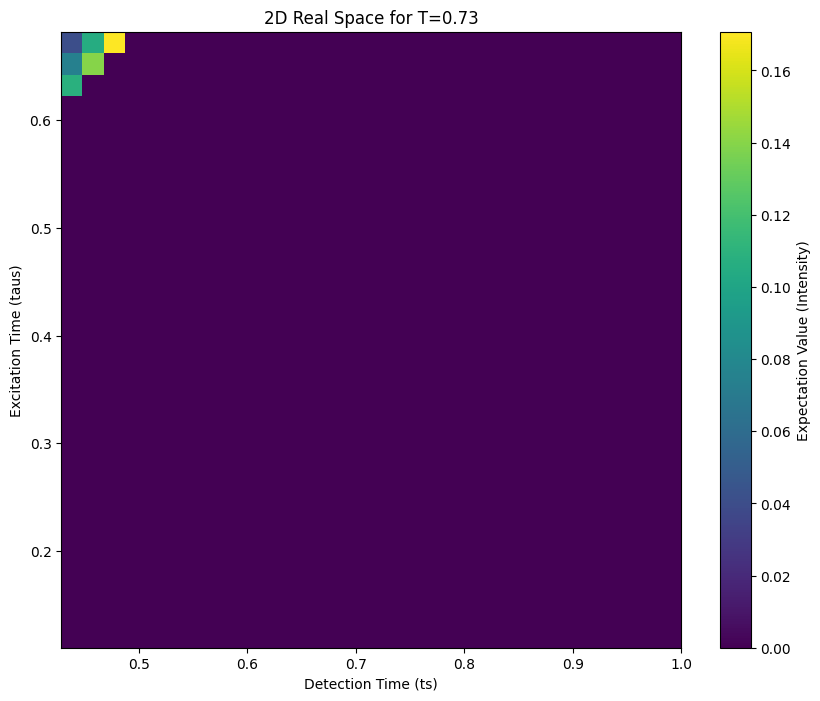

In [18]:
#
# PLOT THE TIME DIMENSIONS ON A GLOBAL GRID
#
T_dictionary_full = {} # save the extended time dim. data in new dict
for idx, (T, T_data) in enumerate(T_dictionary.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue
    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data
    if len(ts) < 2 or len(taus) < 2:  # Ensure only valid indices are selected
        continue

    # Initialize the global extended grid with zeros
    data_extended = np.zeros((len(global_ts), len(global_taus)))

    # Map taus and ts to global indices
    tau_global_indices = [global_taus.index(tau) for tau in taus]  # Global indices for local taus

    t_global_indices = [global_ts.index(t) for t in ts]  # Global indices for local ts

    # Populate data_extended by mapping local 'data' values to global indices
    for local_i, global_i in enumerate(t_global_indices):  # Iterate over t indices
        for local_j, global_j in enumerate(tau_global_indices):  # Iterate over tau indices
            data_extended[global_i, global_j] = data[local_i, local_j]

    # After mapping is done, you can proceed to plot
    plt.figure(figsize=(10, 8))

    # Define extent for axis alignment (using the global ts and taus)
    extent = [global_ts[0], global_ts[-1], global_taus[0], global_taus[-1]]

    # Create the plot using imshow
    plt.imshow(data_extended, extent=extent, origin='lower', aspect='auto', cmap='viridis')

    # Add a colorbar for intensity representation
    plt.colorbar(label="Expectation Value (Intensity)")

    # Add title and axis labels
    plt.title(f"2D Real Space for T={T:.2f}")
    plt.xlabel("Detection Time (ts)")
    plt.ylabel("Excitation Time (taus)")

    # Display the plot
    plt.show()
    T_dictionary_full[T] = {
    "taus": global_taus, # Local taus for the current T
    "ts": global_ts, # Local ts for the current T
    "data": data_extended}
########################################################33333333 REAL SPACE END

<>:59: SyntaxWarning: invalid escape sequence '\o'
<>:60: SyntaxWarning: invalid escape sequence '\o'
<>:59: SyntaxWarning: invalid escape sequence '\o'
<>:60: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_167424/1799303203.py:59: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (arb. units)")
/tmp/ipykernel_167424/1799303203.py:60: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (arb. units)")


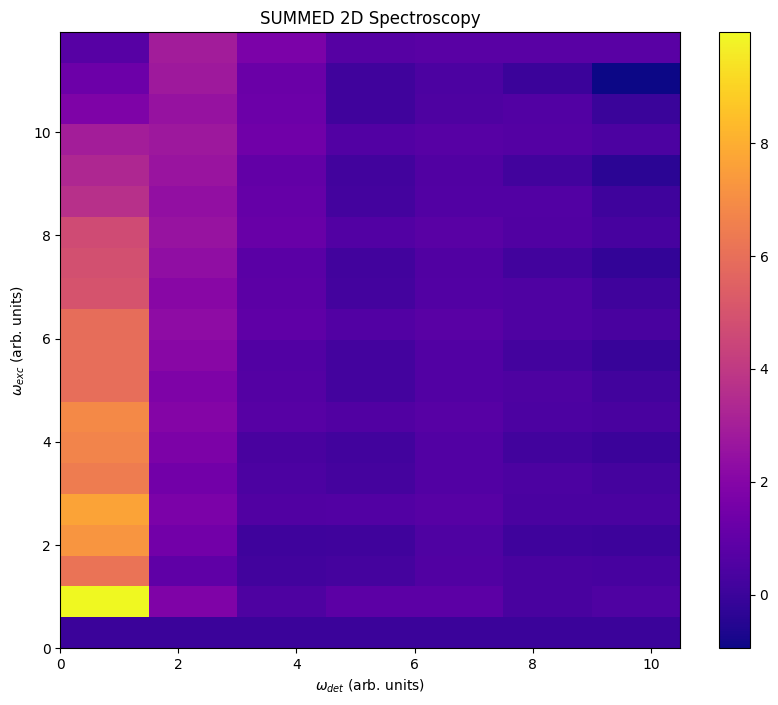

In [113]:
summed_A = 0
#
# PLOT THE GLOBAL DATA IN FREQUENCY SPACE AND THE SUM
#
global_t_freqs = np.fft.fftshift(np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))  # Frequency axis for detection time
global_tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))  # Frequency axis for excitation time
global_t_freqs = global_t_freqs[len(global_ts) // 2:]
global_tau_freqs = global_tau_freqs[len(global_taus) // 2:]

for idx, (T, T_data) in enumerate(T_dictionary_full.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue

    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data

    if len(ts) < 2 or len(taus) < 2:  # Ensure meaningful dimensions
        continue

    # Compute 2D Fourier Transform on the `data` array
    FT_data = np.fft.fft2(data)
    FT_data = np.fft.fftshift(FT_data)
    FT_data = FT_data[len(global_ts) // 2:, len(global_taus) // 2:]

    # Extract the subset of FT_data corresponding to positive frequencies
    A = -global_t_freqs[:, np.newaxis] * np.imag(
        FT_data)

#    # Plot the result using imshow
#     plt.figure(figsize=(10, 8))
#
#    # Define extent based on positive frequency ranges
#    extent = [global_tau_freqs.min(), global_tau_freqs.max(), global_t_freqs.min(), global_t_freqs.max()]
#
#    # Visualize the normalized A as an image
#    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='plasma')
#
#    # Add colorbar to show intensity values
#    plt.colorbar(label="Intensity")
#
#    # Add title and axis labels
#    plt.title(f"2D Spectroscopy Fourier Transform for T={T:.2f}")
#    plt.ylabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
#    plt.xlabel("$\omega_{det}$ (arb. units)")  # Detection frequency
#
#    # Show the plot
#    plt.show()    # Plot the result using imshow

    summed_A += A

summed_A /= len(T_dictionary)
plt.figure(figsize=(10, 8))
extent = [min(global_tau_freqs), max(global_tau_freqs), min(global_t_freqs), max(global_t_freqs)]
plt.imshow(summed_A, extent=extent, origin='lower', aspect='auto', cmap='plasma')
plt.colorbar()
plt.title("SUMMED 2D Spectroscopy")
plt.ylabel("$\omega_{exc}$ (arb. units)")
plt.xlabel("$\omega_{det}$ (arb. units)")
plt.show()

<>:58: SyntaxWarning: invalid escape sequence '\o'
<>:59: SyntaxWarning: invalid escape sequence '\o'
<>:58: SyntaxWarning: invalid escape sequence '\o'
<>:59: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_167424/1983838418.py:58: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
/tmp/ipykernel_167424/1983838418.py:59: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{det}$ (arb. units)")  # Detection frequency


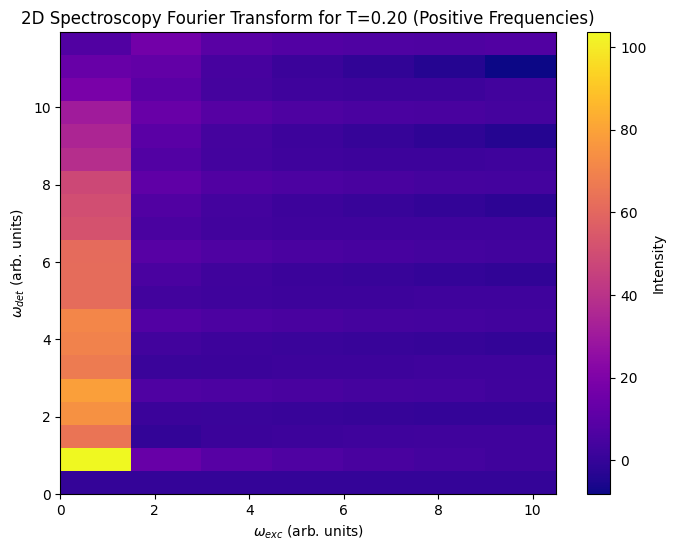

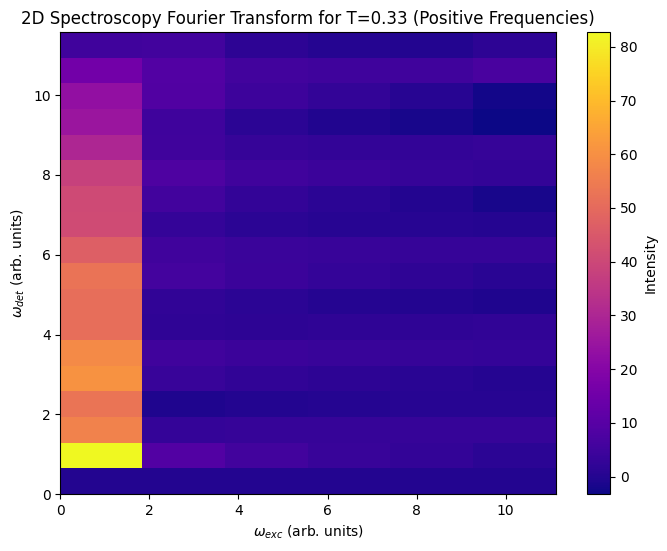

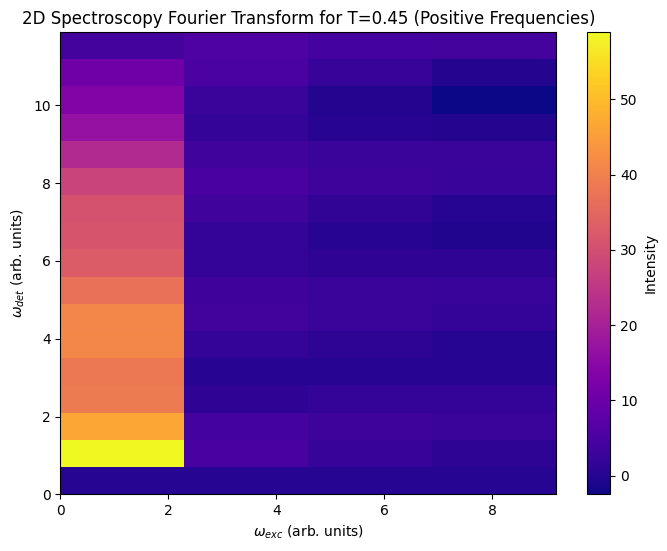

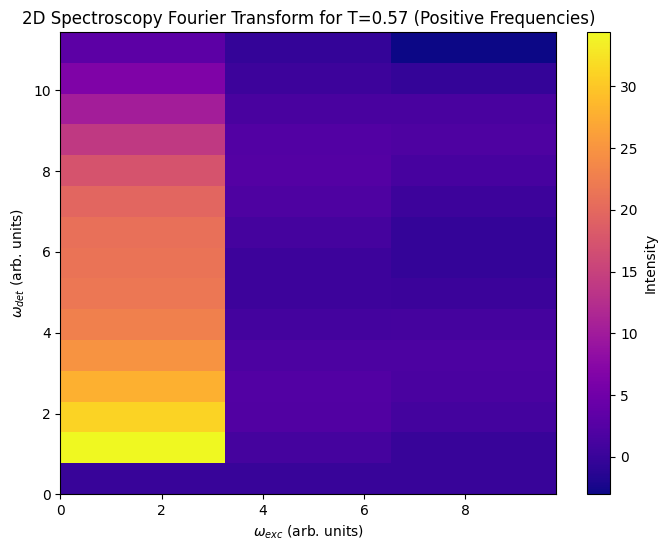

In [115]:
#
# ONLY PLOT THE LOCAL, POSITIVE PARTS OF THE DATA IN FREQUENCY SPACE
#
for idx, (T, T_data) in enumerate(T_dictionary.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue

    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data

    if len(ts) < 2 or len(taus) < 2:  # Ensure meaningful dimensions
        continue

    # Compute 2D Fourier Transform on the `data` array
    FT_data = np.fft.fft2(data)
    FT_data = np.fft.fftshift(FT_data)

    # Calculate frequency axes for ts and taus
    t_freqs = np.fft.fftfreq(len(ts), d=(ts[1] - ts[0]))  # Frequency axis for detection time
    tau_freqs = np.fft.fftfreq(len(taus), d=(taus[1] - taus[0]))  # Frequency axis for excitation time
    t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), d=(ts[1] - ts[0])))
    tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), d=(taus[1] - taus[0])))


    positive_t_indices = np.where(t_freqs >= 0)
    positive_tau_indices = np.where(tau_freqs >= 0)
    t_freqs_positive = t_freqs[positive_t_indices]
    tau_freqs_positive = tau_freqs[positive_tau_indices]

    if len(positive_t_indices[0]) < 2 or len(positive_tau_indices[0]) < 2:  # Ensure meaningful dimensions
        continue

    # Extract the subset of FT_data corresponding to positive frequencies
    A_positive = -t_freqs_positive[:, np.newaxis] * np.imag(
        FT_data[np.ix_(positive_t_indices[0], positive_tau_indices[0])])
    # Normalize A for better visualization
#    max_abs_A = np.max(np.abs(A_positive))
#    if max_abs_A != 0:  # Avoid division by zero
#        A_positive = A_positive / max_abs_A


    # Plot the result using imshow
    plt.figure(figsize=(8, 6))

    # Define extent based on positive frequency ranges
    extent = [tau_freqs_positive.min(), tau_freqs_positive.max(), t_freqs_positive.min(), t_freqs_positive.max()]

    # Visualize the normalized A as an image
    plt.imshow(A_positive, extent=extent, origin='lower', aspect='auto', cmap='plasma')

    # Add colorbar to show intensity values
    plt.colorbar(label="Intensity")

    # Add title and axis labels
    plt.title(f"2D Spectroscopy Fourier Transform for T={T:.2f} (Positive Frequencies)")
    plt.xlabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
    plt.ylabel("$\omega_{det}$ (arb. units)")  # Detection frequency

    # Show the plot
    plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:47: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_72577/2599647320.py:46: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
/tmp/ipykernel_72577/2599647320.py:47: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{det}$ (arb. units)")  # Detection frequency


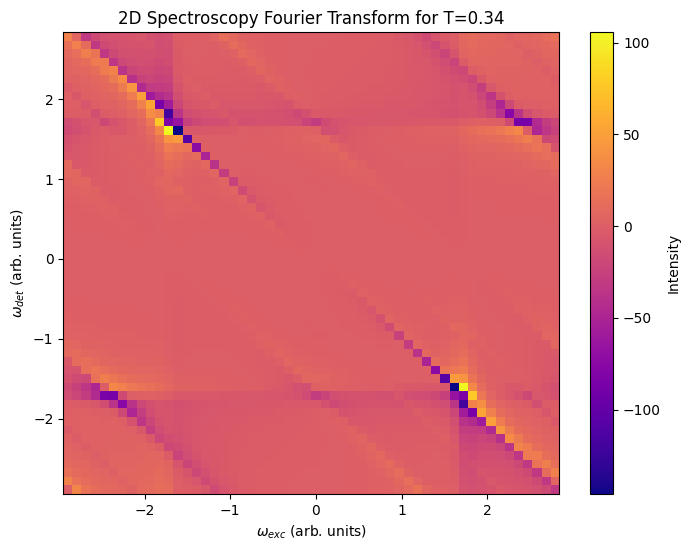

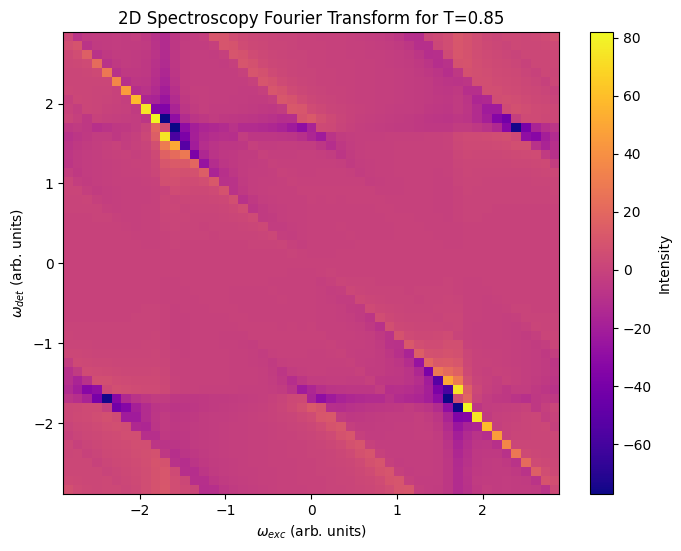

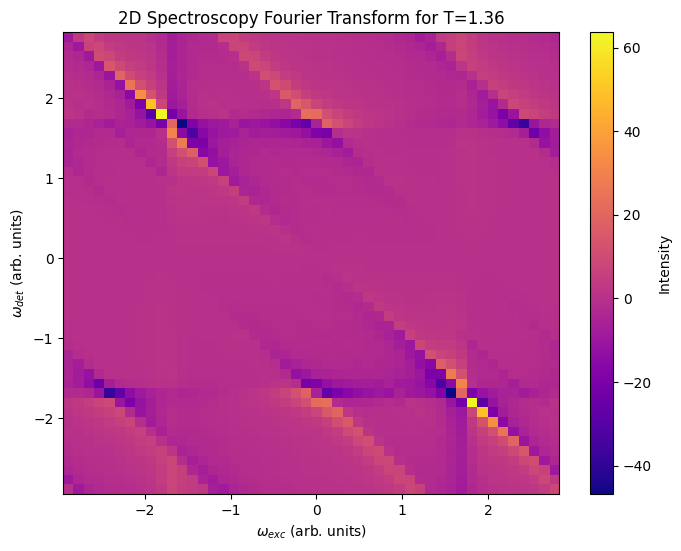

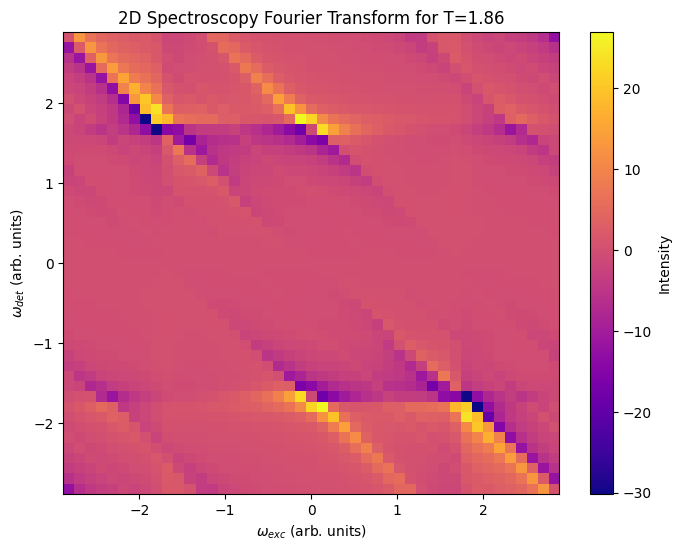

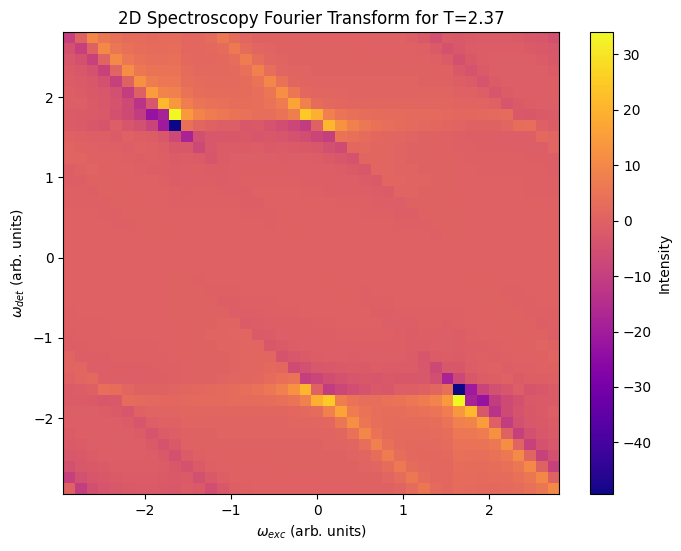

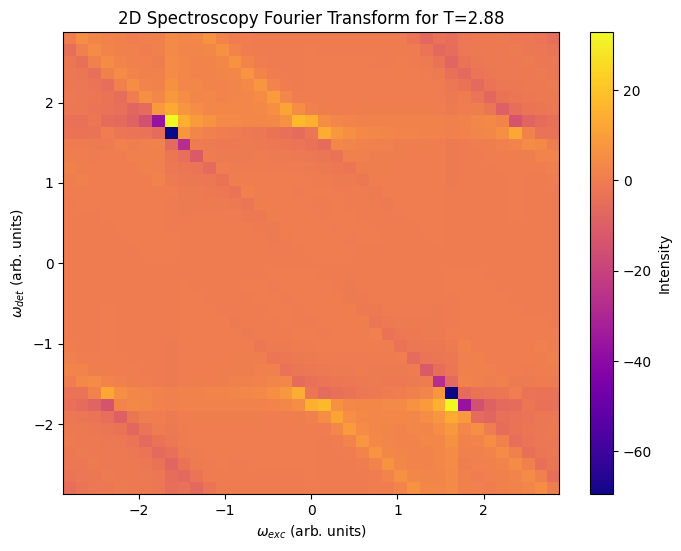

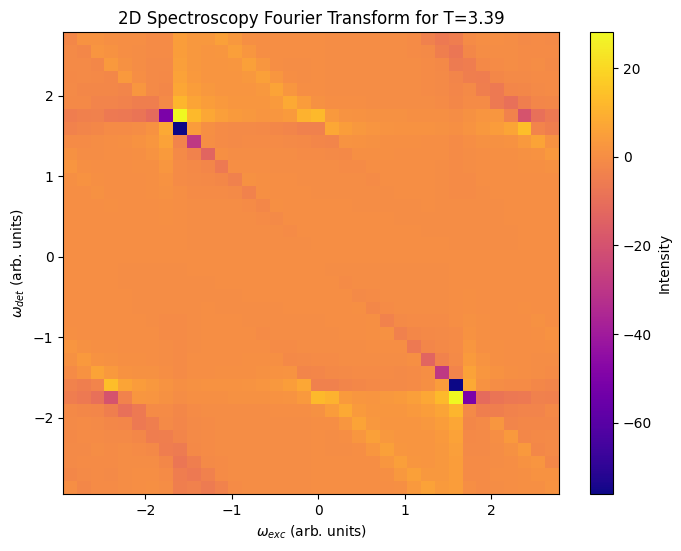

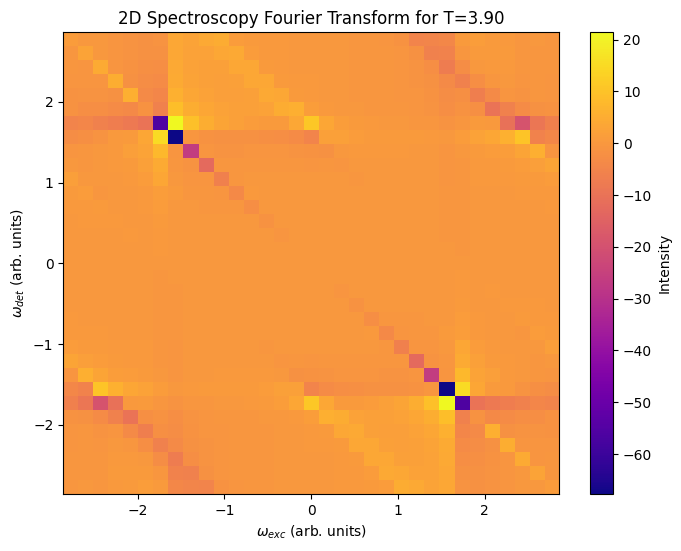

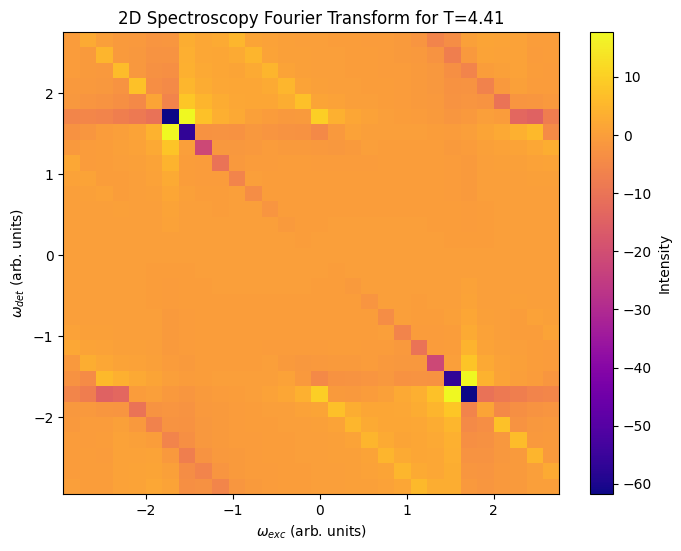

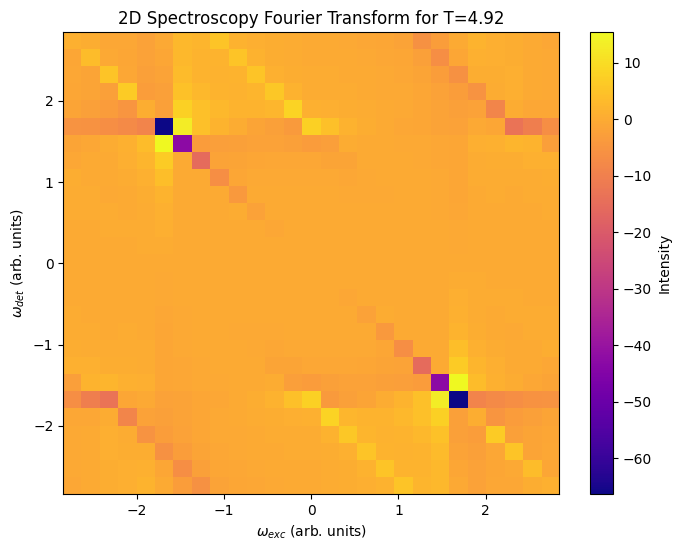

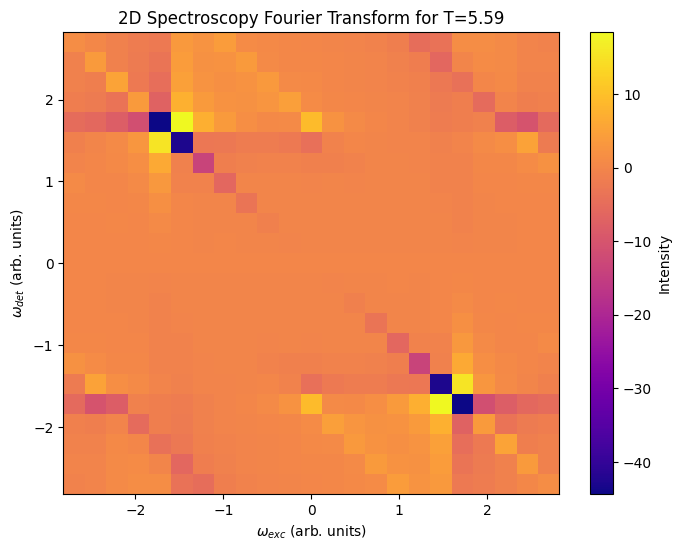

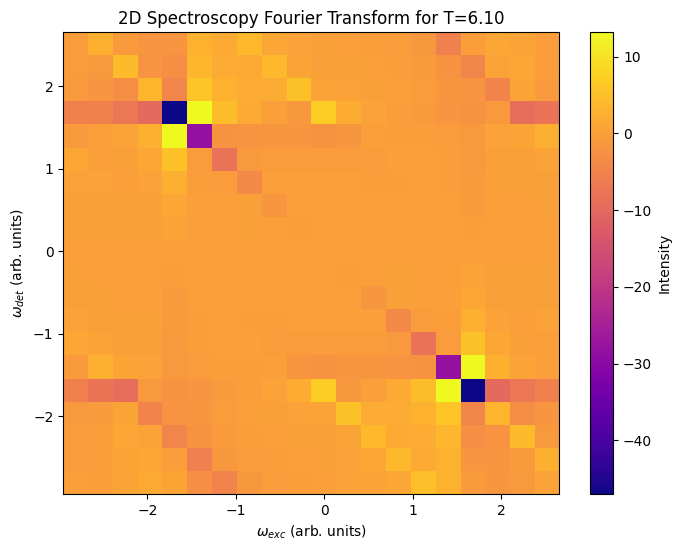

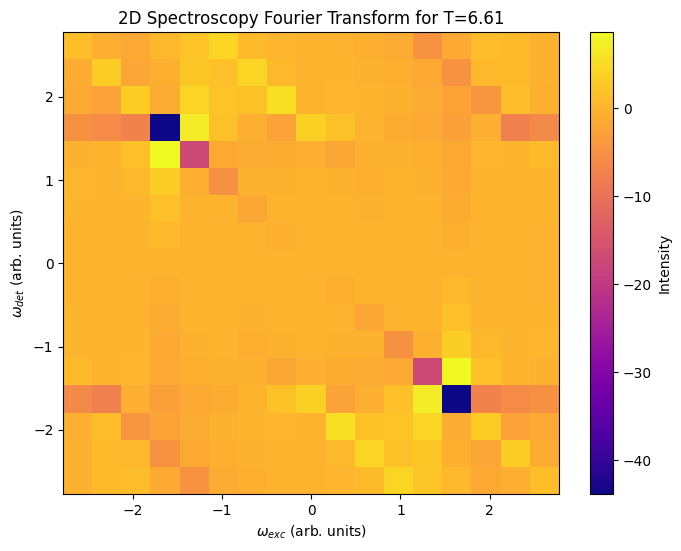

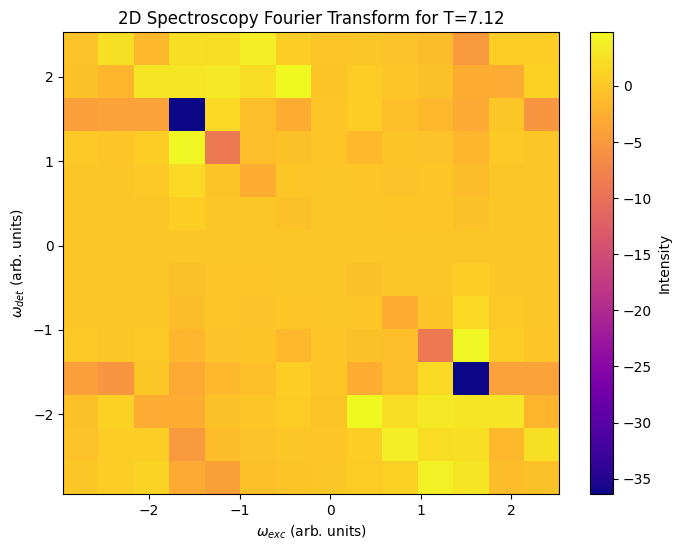

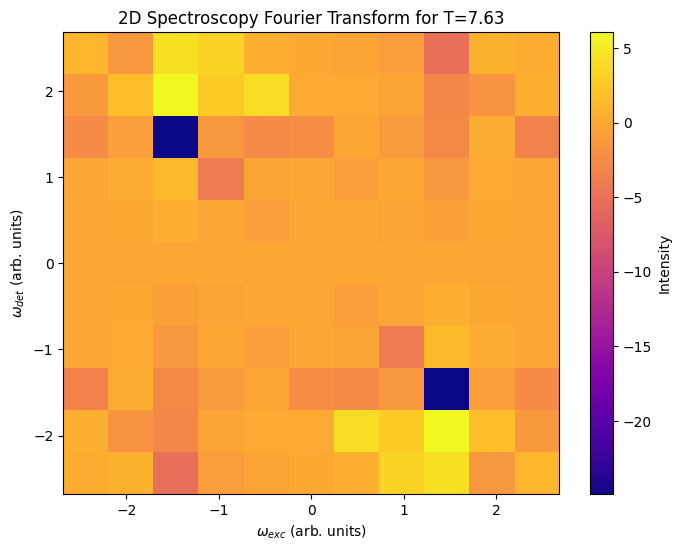

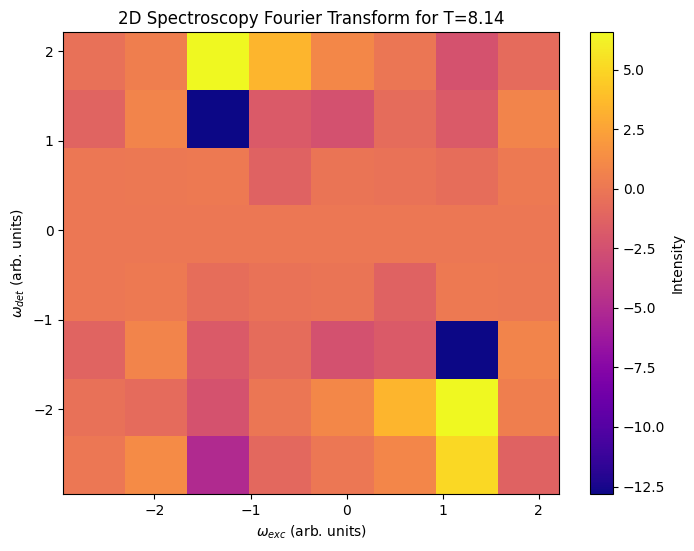

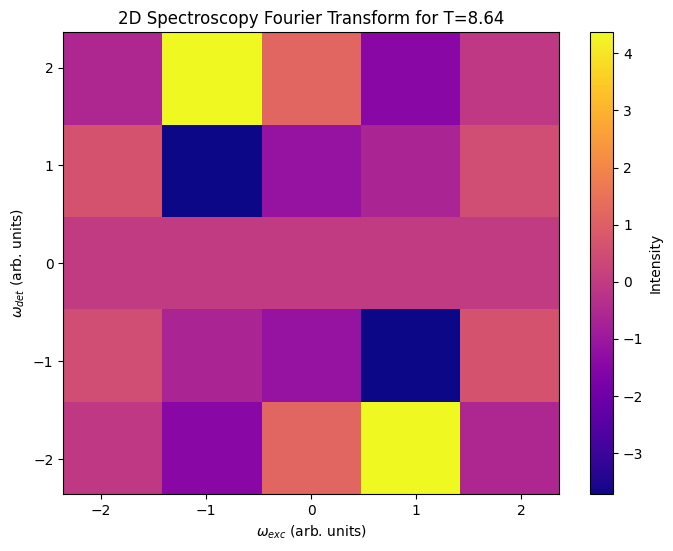

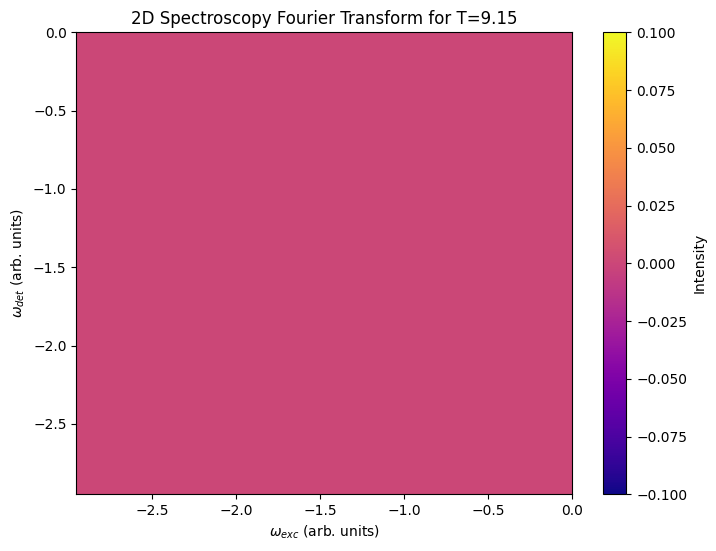

In [188]:
#
# PLOT THE LOCAL PARTS OF THE DATA IN FREQUENCY SPACE
#
for idx, (T, T_data) in enumerate(T_dictionary.items()):
    if idx not in valid_indices:  # Ensure only valid indices are selected
        continue

    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data

    if len(ts) < 2 or len(taus) < 2:  # Ensure meaningful dimensions
        continue

    # Compute 2D Fourier Transform on the `data` array
    FT_data = np.fft.fft2(data)
    FT_data = np.fft.fftshift(FT_data)

    # Calculate frequency axes for ts and taus
    t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), d=(ts[1] - ts[0])))
    tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), d=(taus[1] - taus[0])))
    # Extract the subset of FT_data corresponding to positive frequencies
    A = -t_freqs[:, np.newaxis] * np.imag(
        FT_data)
#    # Normalize A for better visualization
#    max_abs_A = np.max(np.abs(A))
#    if max_abs_A != 0:  # Avoid division by zero
#        A = A / max_abs_A


    # Plot the result using imshow
    plt.figure(figsize=(8, 6))

    # Define extent based on positive frequency ranges
    extent = [tau_freqs.min(), tau_freqs.max(), t_freqs.min(), t_freqs.max()]

    # Visualize the normalized A as an image
    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='plasma')

    # Add colorbar to show intensity values
    plt.colorbar(label="Intensity")

    # Add title and axis labels
    plt.title(f"2D Spectroscopy Fourier Transform for T={T:.2f}")
    plt.xlabel("$\omega_{exc}$ (arb. units)")  # Excitation frequency
    plt.ylabel("$\omega_{det}$ (arb. units)")  # Detection frequency

    # Show the plot
    plt.show()

(2, 7)


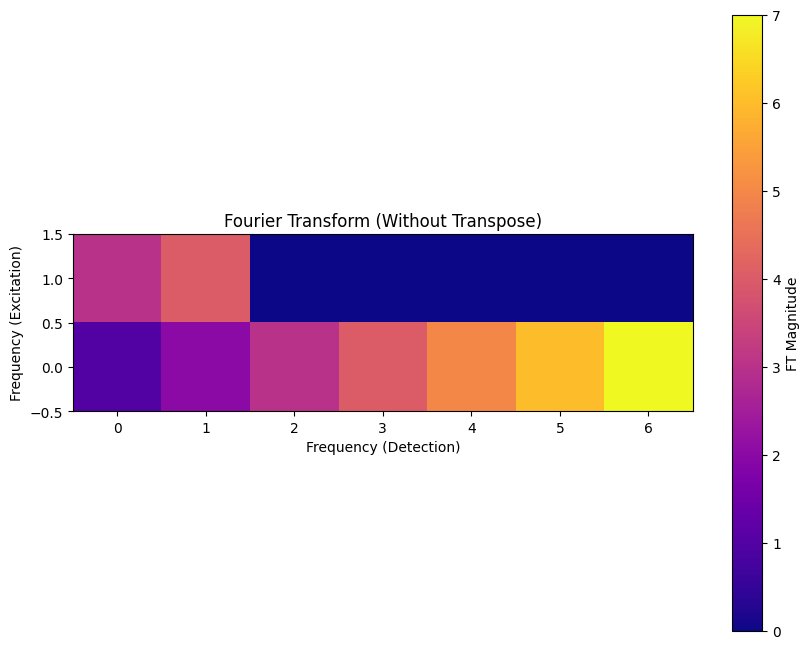

In [97]:
#
# I HAVE TO DO A transpose A.T
#
freq_ts = np.array([0.1, 0.2])  # Frequency (Detection) axis
freq_taus = np.array([0.3, 0.4, 1, 2, 3, 4, 8])  # Frequency (Excitation) axis
ft_data = np.array([[1, 2, 3, 4, 5, 6, 7],
                    [3, 4, 0, 0, 0, 0, 0]])
data = np.zeros((len(freq_ts), len(freq_taus)), dtype=np.float64)
for i, t in enumerate(freq_ts):  # Iterate over detection frequencies (ts)
    for j, tau in enumerate(freq_taus):  # Iterate over excitation frequencies (taus)
        data[i, j] = ft_data[i, j]  # Assign expect_val
print(ft_data.shape)

# Plotting without transpose
plt.figure(figsize=(10, 8))
plt.imshow(data, origin='lower', cmap='plasma')
plt.colorbar(label="FT Magnitude")
plt.title("Fourier Transform (Without Transpose)")
plt.xlabel("Frequency (Detection)")
plt.ylabel("Frequency (Excitation)")
plt.show()